# Abstract

In [57]:
%load_ext autoreload
%autoreload 2
from logisticNewtonAdam import LogisticRegression, GradientDescentOptimizer, NewtonOptimizer, AdamOptimizer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Source Code
[logisticNewtonAdam.py](https://github.com/CameronHudson813/CameronHudson813.github.io/blob/main/posts/Newton's%20Method%20and%20Adam/logisticNewtonAdam.py)

# Newton's Method

# Testing Newton Method Implementation
In order to test the correctness of the Newton's Method implementation (shown in the source code link above), I will demonstrate for a sufficiently small learning rate `α`, Newton's Method coverges to the same result that regular gradient descent would achieve. 

# Generating Classification Data
To test Newton's Method optimization against standard gradient descent, we will generate a 2d set of binary classification data with the `generate_classification_data` function below, as well as a visualization of the data and classes with the `plot_classification_data` function. 

In [253]:
import torch
def generate_classification_data(n_points = 300, noise = 0.5, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

X, y = generate_classification_data(noise = 0.5)

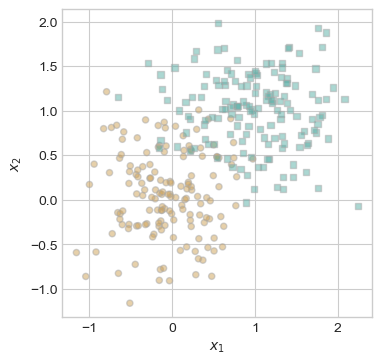

In [254]:
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

def plot_classification_data(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [0, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = 2*y[ix]-1, facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

fig, ax = plt.subplots(1, 1, figsize = (4, 4))
plot_classification_data(X, y, ax)


# Experiments
Now that we have some a binary classification dataset, we can use it to perform various experiments to fully illstrate Newton's Method opitimization.

## Experiment 1: Comparing Standard Graident Descent and Newton's Method
Now that we have a binary classification dataset, we can declare two Logistic Regression models, one that will use the standard gradient opitimzer and one that will use Newton's Method optimization.

# Breast Cancer Dataset for Experiements
I will be using the Breast Cancer dataset from kaggle to show how standard gradient descent optimization and Newton's Method opitimization works on a real, empirical dataset. Below is the conversion from the csv into a dataframe, with the `head()` function giving us an idea of the data we are working with.

In [255]:
import pandas as pd
train = pd.read_csv("breast-cancer.csv")
train.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


# Data Preprocessing
This data requires some processing in order to work for both standard gradient descent and Newtons Method. Mainly, we must seperating the predictive features from the labels, drop unnecessary columns like `id` as well as drop rows that have `NaN` values. In order to ensure that the input matrix is full rank and therefore invertible, as Newtons Method requires the hessian of the input matrix to be inverted, we must scale the features using the `StandardScaler()` function as well as add a column of 1's. With these changes, we can be confident that the input matrix will not be singular and can be inverted, allowing Newton's Method of optimization to work as expected.

In [ ]:
# from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import StandardScaler

def prepare_data(df):
    df = df.dropna()
    y = np.where(df['diagnosis'] == "M", True, False)
    df = df.drop(['diagnosis'], axis = 1)
    df = df.drop(['id'], axis = 1)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df)
    return X_scaled, y

X, y = prepare_data(train)
X = torch.from_numpy(X.astype(np.float32))
y = torch.from_numpy(y).float()
X = torch.cat([X, torch.ones(X.shape[0], 1)], dim=1)

# Training the Models
Now that we have processed the data, we are ready to train two logistic regression models on this data, with one using standard gradient descent and the other using Newton's Method.

In [240]:
# Logistic Regression model with gradient descent optimizer
LR_GD = LogisticRegression()
opt_GD = GradientDescentOptimizer(LR_GD)

#Logistic Regression model with Newton's Method optimizer 
LR_NM = LogisticRegression()
opt_NM = NewtonOptimizer(LR_NM)

num_iterations = 1000
for _ in range(num_iterations):
    opt_GD.step(X, y, 0.1, 0, False, 0)
    opt_NM.step(X, y, 1)
print(f"Gradient Descent Logistic Regression Loss: {LR_GD.loss(X,y)}\nNewton's Method Logistic Regression Loss: {LR_NM.loss(X,y)}\n")



Gradient Descent Logistic Regression Loss: 0.05876803398132324
Newton's Method Logistic Regression Loss: 0.08070827275514603



# Results
We can see that when giving the standard gradient descent optimizer a learning rate of `0.1` and the Newton's Method optimizer a learning rate of `1`, they produce a similar loss in the same amount of iterations.

## Experiment 2: Faster Convergence Using Newton's Method
Through this experiment I will demonstrate that Newton's Method in certain circumstances can have a much faster convergence than Standard Gradient Descent optimizaiton. The circumstance shown below is when the data has low noise and low number of points and dimensions, and gradient descent is using a learning rate of `0.1` while Newton's Method is using a learning rate of `100`. In this case, Newton's Method is able to converge faster than standard gradient descent.

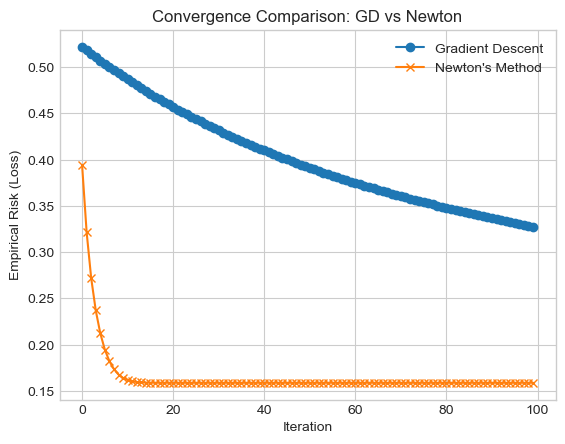

In [259]:
LR_GD = LogisticRegression()
opt_GD = GradientDescentOptimizer(LR_GD)

#Logistic Regression model with Newton's Method optimizer 
LR_NM = LogisticRegression()
opt_NM = NewtonOptimizer(LR_NM)
# Track loss over iterations
losses_gd = []
losses_nm = []

# Training loop
n_steps = 100
for _ in range(n_steps):
    # Gradient Descent
    opt_GD.step(X, y, 0.1, 0, False, 0)
    loss_gd = LR_GD.loss(X, y).item()
    losses_gd.append(loss_gd)

    # Newton's Method
    opt_NM.step(X, y, alpha=100)
    loss_nm = LR_NM.loss(X, y).item()
    losses_nm.append(loss_nm)

# Plot convergence
plt.plot(losses_gd, label="Gradient Descent", marker='o')
plt.plot(losses_nm, label="Newton's Method", marker='x')
plt.xlabel("Iteration")
plt.ylabel("Empirical Risk (Loss)")
plt.title("Convergence Comparison: GD vs Newton")
plt.legend()
plt.grid(True)
plt.show()

# Results
As demonsrated by the graph, in 100 iterations optimization with Newton's Method reaches near zero loss, while the loss using standard gradient descent for optimization is around `0.25`.

# Adam Optimization
We now move on to our second advanced optimizer, Adam optimization, where its implementation is also shown in the source code at the top of this blog post. Below, I compare Adam optimization to standard minibatch gradient descent with various step sizes shared between the two optimization algorithms.

In [257]:
import pandas as pd

num_iterations = 1000
step_size = [0.0001, 0.001, 0.01, 0.1, 1]

minibatch_GD_loss = []
adam_OPT_loss = []

for step in step_size: 
    LR_GD = LogisticRegression()
    opt_GD = GradientDescentOptimizer(LR_GD)

    LR_Adam = LogisticRegression()
    opt_Adam = AdamOptimizer(LR_Adam)

    for _ in range(num_iterations):
        # Using the same dataset X and y as with newtons method
        opt_Adam.step(X, y, step, 0.9, 0.999, 1e-8, 10)
        opt_GD.step(X, y, step, 0.9, True, 10)
    adam_OPT_loss.append(LR_Adam.loss(X, y).item())
    minibatch_GD_loss.append(LR_GD.loss(X, y).item())
# Make some type of table
#first convert to series
df = pd.DataFrame({
    "Minibatch GD Loss": minibatch_GD_loss,
    "Adam Optimizer Loss": adam_OPT_loss
}, index=step_size)

print(df)

        Minibatch GD Loss  Adam Optimizer Loss
0.0001           0.646615             0.618412
0.0010           0.528996             0.399902
0.0100           0.333009             0.178175
0.1000           0.181183             0.159312
1.0000           0.160076             0.262893


# Results
On average with the same batch size of 10, using the adam opitmizer converges faster than standard minibatch gradient descent when both optimizers have matching alpha values.

# Comparing Adam and Newton's Method Optimization
Now, I will demonstrate the difference of the speed of convergence between using Adam opitimization or Newton's Method. The way I will show this speed is by using the `time()` function, which will allow us to track the time of a particular operation. For `1000` iterations, I perform training run for Adam optimization and Newton's Method optimization, which will stop when it has reached a loss threshold of `0.2`. With this, we can see the time difference between how long it takes for each optimizer to reach a loss of `0.2` on the same dataset.

In [185]:
import time

X, y = generate_classification_data(noise = 0.8)
LR_Adam = LogisticRegression()
opt_Adam = AdamOptimizer(LR_Adam)

LR_NM = LogisticRegression()
opt_NM = NewtonOptimizer(LR_NM)


LOSS_THRESHOLD = 0.2
MAX_ITER = 1000

start_adam = time.time()

for _ in range(MAX_ITER):
    opt_Adam.step(X, y, step, 0.9, 0.999, 1e-8, 10)
    loss = LR_Adam.loss(X, y).item()
    if loss < LOSS_THRESHOLD:
        break

end_adam = time.time()
adam_time = end_adam - start_adam

start_newton = time.time()

for _ in range(MAX_ITER):
    opt_NM.step(X, y, 0.9)
    loss = LR_NM.loss(X, y).item()
    if loss < LOSS_THRESHOLD:
        break

end_newton = time.time()
newton_time = end_newton - start_newton

print(f"Newton's Method Optimization converge time: {newton_time}\nAdam Optimization converge time: {adam_time}")


Newton's Method Optimization converge time: 0.043290138244628906
Adam Optimization converge time: 0.06393694877624512


# Results
As the output shows, for the same dataset, Newton's Method seemingly reaches a loss of `0.2` faster than Adam optimization, however the times are very similar and thus do not definitively prove one of these optimizers being better than the other.

# Conclusion
Through the implementations of Newton's Method and Adam optimization, as well as through experimenting with the optimizers on various datasets, I learned the general behavior of both optimizing algorithms. Through experimenting with Netwon's Method versus standard gradient descent, I learned that will a large learning rate with standard gradient descent usually causes the optimizer to overshoot, large learning rates with Newton's Method speeds up convergence considerably. I also came to understand how Adam optimization builds off of stochastic gradient descent and can lead to faster convergence.